In [1]:
import multirex as mrex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import pandas as pd
from tqdm import tqdm
import os
import re
import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.exceptions import DataConversionWarning
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
## general metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# accuracy, f1 , recall, precision
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
## hamming loss and exact match
from sklearn.metrics import hamming_loss, accuracy_score

#%matplotlib inline

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#load txt waves.txt
waves=np.loadtxt("waves.txt")
n_points = len(waves)
indices = np.linspace(0, len(waves) - 1, n_points, endpoint=True)
indices = np.round(indices).astype(int)  # Redondear los índices y convertir a entero

# Seleccionar los elementos de la lista usando los índices
puntos_seleccionados = waves[indices]
waves=puntos_seleccionados
wn_grid=np.sort((10000/waves))

Loading MultiREx version 0.2.3


In [2]:
def apply_contaminations_from_files(
    contamination_files, df, n_points,
):
    """
    Aplica múltiples contaminaciones a los datos desde una lista de archivos de contaminación
    y devuelve un DataFrame con todas las combinaciones, incluyendo el caso sin contaminación.

    Parámetros:
        contamination_files (list de str): Lista de rutas a archivos .txt con contaminaciones.
        df (pandas.DataFrame): DataFrame original sobre el cual se aplicarán las contaminaciones.
        n_points (int): Número de columnas a las que se aplicará la contaminación.

    Retorna:
        pandas.DataFrame: DataFrame con todas las combinaciones de contaminaciones,
                          incluyendo sin contaminación, y con columnas adicionales 'f_spot' y 'f_fac'.
    """
    # Lista para almacenar los DataFrames resultantes
    df_list = []

    # Caso sin contaminación
    df_no_contam = df.copy()
    df_no_contam['f_spot'] = 0.0
    df_no_contam['f_fac'] = 0.0
    # Reordenar columnas para que 'f_spot' y 'f_fac' estén al inicio
    cols = ['f_spot', 'f_fac'] + [
        col for col in df_no_contam.columns if col not in ['f_spot', 'f_fac']
    ]
    df_no_contam = df_no_contam[cols]
    df_list.append(df_no_contam)

    # Expresión regular para extraer f_spot y f_fac del nombre del archivo
    pattern = r"fspot(?P<f_spot>[0-9.]+)_ffac(?P<f_fac>[0-9.]+)\.txt$"

    for file_path in contamination_files:
        # Verificar que el archivo exista
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"El archivo {file_path} no existe.")

        # Extraer f_spot y f_fac del nombre del archivo
        filename = os.path.basename(file_path)
        match = re.search(pattern, filename)
        if not match:
            raise ValueError(
                f"El nombre del archivo '{filename}' no coincide con el patrón esperado."
            )

        f_spot = float(match.group('f_spot'))
        f_fac = float(match.group('f_fac'))

        # Leer los valores de contaminación desde el archivo txt
        try:
            # Cargar los datos asegurando que siempre haya al menos dos dimensiones
            contamination_data = np.loadtxt(file_path, ndmin=2)
            # Si la contaminación tiene al menos dos columnas, tomar la segunda
            if contamination_data.shape[1] >= 2:
                contam_values = contamination_data[:, 1]
            else:
                contam_values = contamination_data.flatten()

            # Verificar que la longitud de contam_values coincide con n_points
            if len(contam_values) != n_points:
                raise ValueError(
                    f"El número de valores de contaminación en '{filename}' ({len(contam_values)}) "
                    f"no coincide con n_points ({n_points})."
                )
        except Exception as e:
            raise ValueError(f"Error al leer el archivo {file_path}: {e}")
        contam_values = contam_values[::-1]
        # Crear una copia del DataFrame original
        df_contam = df.copy()

        # Aplicar la contaminación multiplicando las últimas n_points columnas por contam_values
        data_columns = df_contam.columns[-n_points:]
        # Multiplicar las columnas por contam_values (aplicación columnar)
        df_contam[data_columns] = df_contam[data_columns].multiply(contam_values, axis=1)

        # Añadir columnas 'f_spot' y 'f_fac'
        df_contam['f_spot'] = f_spot
        df_contam['f_fac'] = f_fac

        # Reordenar columnas para que 'f_spot' y 'f_fac' estén al inicio
        cols = ['f_spot', 'f_fac'] + [
            col for col in df_contam.columns if col not in ['f_spot', 'f_fac']
        ]
        df_contam = df_contam[cols]

        # Añadir el DataFrame contaminado a la lista
        df_list.append(df_contam)

    # Concatenar todos los DataFrames en uno solo
    df_final = pd.concat(df_list, ignore_index=True)

    # Definir atributos .data y .params en el DataFrame final
    df_final.data = df_final.iloc[:, -n_points:]
    df_final.params = df_final.iloc[:, :-n_points]

    return df_final

In [3]:
def normalize_min_max_by_row(df):
    min_by_row = df.min(axis=1)
    max_by_row = df.max(axis=1)
    # Diferencia entre máximos y mínimos
    range_by_row = max_by_row - min_by_row
    normalized = (df.sub(min_by_row, axis=0)).div(range_by_row, axis=0)
    normalized[range_by_row == 0] = 0
    return normalized

def string_to_list(string):
    return ast.literal_eval(string)

def plot_confusion_matrix(y_test, y_pred, labels, display_labels, title):
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(values_format=".0%", colorbar=True, ax=ax)
    disp.im_.colorbar.remove()  
    disp.im_.set_clim(0, 1) 

    cbar = fig.colorbar(disp.im_, ax=ax)
    cbar.ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) 

    # Ajustes de formato y título
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.title(title, fontsize=20)

    plt.show()

def remove_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [4]:
import pandas as pd

contamination_files = [
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.01_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.08_ffac0.70.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.08.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.54.txt',
    'stellar_contamination/TRAPPIST-1_contam_fspot0.26_ffac0.70.txt'
]

def filtrar_filas(df):
    """
    Filtra las filas de un DataFrame donde al menos una de las columnas
    "atm CH4", "atm O3" o "atm H2O" tenga un valor mayor o igual a -8.

    Si ninguna de estas columnas está presente, devuelve el DataFrame sin cambios.
    """
    columnas_a_filtrar = ["atm CH4", "atm O3", "atm H2O"]
    columnas_presentes = [col for col in columnas_a_filtrar if col in df.columns]

    for chem in columnas_presentes:

        df = df[df[chem]>=-8]

        # Definir atributos .data y .params en el DataFrame final
        df.data = df.iloc[:, -n_points:]
        df.params = df.iloc[:, :-n_points]

    return df

# Procesamiento de los diferentes datasets

try:
    airless_data = pd.read_csv("spec_data/airless_data.csv")
    airless_data["label"] = 0
    airless_data = apply_contaminations_from_files(contamination_files, airless_data, n_points)
except Exception as e:
    print(f"Error al procesar airless_data: {e}")

try:
    CO2_data = pd.read_csv("spec_data/CO2_data.csv")
    CO2_data["label"] = 0
    CO2_data = apply_contaminations_from_files(contamination_files, CO2_data, n_points)
except Exception as e:
    print(f"Error al procesar CO2_data: {e}")

try:
    CH4_data = pd.read_csv("spec_data/CH4_data.csv")
    CH4_data["label"] = 1
    CH4_data = filtrar_filas(CH4_data)  # Aplicar el filtrado
    CH4_data = apply_contaminations_from_files(contamination_files, CH4_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_data: {e}")

try:
    O3_data = pd.read_csv("spec_data/O3_data.csv")
    O3_data["label"] = 1
    O3_data = filtrar_filas(O3_data)  # Aplicar el filtrado
    O3_data = apply_contaminations_from_files(contamination_files, O3_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_data: {e}")

try:
    H2O_data = pd.read_csv("spec_data/H2O_data.csv")
    H2O_data["label"] = 0
    H2O_data = filtrar_filas(H2O_data)  # Aplicar el filtrado
    H2O_data = apply_contaminations_from_files(contamination_files, H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar H2O_data: {e}")

try:
    CH4_O3_data = pd.read_csv("spec_data/CH4_O3_data.csv")
    CH4_O3_data["label"] = 1
    CH4_O3_data = filtrar_filas(CH4_O3_data)  # Aplicar el filtrado
    CH4_O3_data = apply_contaminations_from_files(contamination_files, CH4_O3_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_data: {e}")

try:
    CH4_H2O_data = pd.read_csv("spec_data/CH4_H2O_data.csv")
    CH4_H2O_data["label"] = 1
    CH4_H2O_data = filtrar_filas(CH4_H2O_data)  # Aplicar el filtrado
    CH4_H2O_data = apply_contaminations_from_files(contamination_files, CH4_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_H2O_data: {e}")

try:
    O3_H2O_data = pd.read_csv("spec_data/O3_H2O_data.csv")
    O3_H2O_data["label"] = 1
    O3_H2O_data = filtrar_filas(O3_H2O_data)  # Aplicar el filtrado
    O3_H2O_data = apply_contaminations_from_files(contamination_files, O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar O3_H2O_data: {e}")

try:
    CH4_O3_H2O_data = pd.read_csv("spec_data/CH4_O3_H2O_data.csv")
    CH4_O3_H2O_data["label"] = 1
    CH4_O3_H2O_data = filtrar_filas(CH4_O3_H2O_data)  # Aplicar el filtrado
    CH4_O3_H2O_data = apply_contaminations_from_files(contamination_files, CH4_O3_H2O_data, n_points)

except Exception as e:
    print(f"Error al procesar CH4_O3_H2O_data: {e}")


C:\Users\User\AppData\Local\Temp\ipykernel_8988\951796714.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam['f_spot'] = f_spot
C:\Users\User\AppData\Local\Temp\ipykernel_8988\951796714.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_contam['f_fac'] = f_fac
C:\Users\User\AppData\Local\Temp\ipykernel_8988\951796714.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

## Train data

In [5]:
import numpy as np
import pandas as pd
import warnings

def generate_df_with_noise_std(df, n_repeat, noise_std, seed=None):
    """
    Genera un nuevo DataFrame aplicando ruido Gaussiano de desviación estándar especificada
    a los espectros de manera vectorizada y concatena el resultado con otro DataFrame que
    contiene otras columnas de información.

    Parámetros:
    - df: DataFrame con parámetros y espectros. Debe tener atributos 'params' y 'data'.
          Ejemplo: df.params, df.data
    - n_repeat: Número de veces que se replica cada espectro.
    - noise_std: Desviación estándar del ruido a aplicar. Puede ser un número único o una
                 lista/array con una desviación estándar para cada espectro.
    - seed: Semilla para el generador de números aleatorios (opcional).

    Retorna:
    - Nuevo DataFrame con parámetros y espectros con ruido agregado en el mismo formato
      que el DataFrame de entrada. df.params, df.data
    """
    # Verificación de atributos 'params' y 'data' en el DataFrame
    if not hasattr(df, "params"):
        print("Advertencia: No se encontró el atributo 'params' en el DataFrame.")
        df_params = pd.DataFrame()
        if not hasattr(df, "data"):
            print("Advertencia: No se encontró el atributo 'data' en el DataFrame.",
                  "Se considerará que el DataFrame contiene solo datos espectrales.")
            df_spectra = df
    else:
        if not hasattr(df, "data"):
            raise ValueError("El DataFrame debe tener un atributo 'data'.")
        else:
            df_params = df.params
            df_spectra = df.data

    # Validaciones de tipos y valores de los parámetros
    if not isinstance(df_spectra, pd.DataFrame):
        raise ValueError("df_spectra debe ser un pandas DataFrame.")
    if not isinstance(df_params, pd.DataFrame):
        raise ValueError("df_params debe ser un pandas DataFrame.")
    if (not isinstance(n_repeat, int) or n_repeat <= 0):
        raise ValueError("n_repeat debe ser un entero positivo.")
    if isinstance(noise_std, (int, float)):
        if noise_std < 0:
            raise ValueError("noise_std debe ser un número positivo.")
    elif isinstance(noise_std, (list, np.ndarray, pd.Series)):
        if not all(n > 0 for n in noise_std):
            raise ValueError("Todos los valores en noise_std deben ser positivos.")
        if len(noise_std) != len(df_spectra):
            raise ValueError("La longitud de noise_std debe coincidir con el número de espectros en df.")
    else:
        raise ValueError("noise_std debe ser un número positivo o una lista/array de números positivos.")
    if (seed is not None and
        (not isinstance(seed, int) or seed < 0)):
        raise ValueError("seed debe ser un entero no negativo.")

    # Configuración de la semilla para reproducibilidad
    if seed is not None:
        np.random.seed(seed)  

    # Replicación del DataFrame de espectros según el factor de repetición
    df_spectra_replicated = pd.DataFrame(
        np.repeat(df_spectra.values, n_repeat, axis=0),
        columns=df_spectra.columns
    )

    # Manejo de noise_std: si es escalar, se expande; si es array, se replica según n_repeat
    if isinstance(noise_std, (int, float)):
        noise_replicated = np.full(df_spectra_replicated.shape, noise_std)
    else:
        noise_array = np.array(noise_std)
        noise_replicated = np.repeat(noise_array[:, np.newaxis], n_repeat, axis=0)
        noise_replicated = np.tile(noise_replicated, (1, df_spectra_replicated.shape[1]))

    # Aplicación vectorizada del ruido Gaussiano
    gaussian_noise = np.random.normal(0, noise_replicated, df_spectra_replicated.shape)
    df_spectra_replicated += gaussian_noise

    # Replicación del DataFrame de parámetros para que coincida con el número de filas de los espectros replicados
    df_other_columns_replicated = pd.DataFrame(
        np.repeat(df_params.values, n_repeat, axis=0),
        columns=df_params.columns
    )

    # Inserción de la columna 'noise' y 'noise_std' en los parámetros replicados
    if isinstance(noise_std, (int, float)):
        df_other_columns_replicated.insert(0, 'noise_std', noise_std)
    else:
        df_other_columns_replicated.insert(0, 'noise_std', np.repeat(noise_std, n_repeat))
    df_other_columns_replicated.insert(1, 'n_repeat', n_repeat)

    # Concatenación de parámetros y espectros ruidosos
    df_final = pd.concat(
        [df_other_columns_replicated.reset_index(drop=True),
         df_spectra_replicated.reset_index(drop=True)],
        axis=1
    )

    # Asignación de atributos 'data' y 'params' al DataFrame final
    warnings.filterwarnings("ignore")
    df_final.data = df_final.iloc[:, -df_spectra_replicated.shape[1]:]
    df_final.params = df_final.iloc[:, :df_other_columns_replicated.shape[1]]
    warnings.filterwarnings("default")
    
    return df_final


### SNR = 1

In [6]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=1     
)["noise"][1]


SNR1_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR1_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = noise     
)

SNR1_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR1_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = noise
)
    
    
SNR1_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR1_df = pd.concat(
    [
        SNR1_CO2_data,
        SNR1_CH4_data,
        SNR1_O3_data,
        SNR1_H2O_data,
        SNR1_CH4_O3_data,
        SNR1_CH4_H2O_data,
        SNR1_O3_H2O_data,
        SNR1_CH4_O3_H2O_data,
        SNR1_airless_data
        
    ],
    ignore_index=True
) 

del (
        SNR1_CO2_data,
        SNR1_CH4_data,
        SNR1_O3_data,
        SNR1_H2O_data,
        SNR1_CH4_O3_data,
        SNR1_CH4_H2O_data,
        SNR1_O3_H2O_data,
        SNR1_CH4_O3_H2O_data,
        SNR1_airless_data
        
)

gc.collect()

print(SNR1_df["label"].value_counts())

label
0    460000
1    369600
Name: count, dtype: int64


### SNR = 3

In [15]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=3     
)["noise"][1]


SNR3_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR3_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = noise     
)

SNR3_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=30, # 350 for graph
    noise_std = noise
)

SNR3_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR3_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=30,
    noise_std = noise
)

SNR3_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = noise
)
    
SNR3_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR3_df = pd.concat(
    [
        SNR3_CO2_data,
        SNR3_CH4_data,
        SNR3_O3_data,
        SNR3_H2O_data,
        SNR3_CH4_O3_data,
        SNR3_CH4_H2O_data,
        SNR3_O3_H2O_data,
        SNR3_CH4_O3_H2O_data,
        SNR3_airless_data
    ],
    ignore_index=True
) 


del (
        SNR3_CO2_data,
        SNR3_CH4_data,
        SNR3_O3_data,
        SNR3_H2O_data,
        SNR3_CH4_O3_data,
        SNR3_CH4_H2O_data,
        SNR3_O3_H2O_data,
        SNR3_CH4_O3_H2O_data,
        SNR3_airless_data
        
)

gc.collect()

print(SNR3_df["label"].value_counts())

label
1    984000
0    460000
Name: count, dtype: int64


#### plot autoencoder process

In [16]:
from tensorflow import keras 

encoder = keras.models.load_model("AE.keras")

# Display the first few rows of the DataFrame
SNR3_df.head()

# Filter DataFrame for rows where f_spot == 0.08 and f_fac == 0.54
auto_SNR3_df = SNR3_df[
    (SNR3_df["f_spot"] == 0.08) & (SNR3_df["f_fac"] == 0.54)
]

# Normalize the last n_points columns by row
auto_SNR3_df.iloc[:, -n_points:] = normalize_min_max_by_row(
    auto_SNR3_df.iloc[:, -n_points:]
)

# Predict the encoded values
X = auto_SNR3_df.iloc[:, -n_points:].values
X = encoder.predict(X)

# Copy the original DataFrame and replace the last n_points columns with predicted values
auto_reconstructed_SNR3_df = auto_SNR3_df.copy()
auto_reconstructed_SNR3_df.iloc[:, -n_points:] = X

# Extract values for non-atmospheric CO2 condition from both original and
# reconstructed DataFrames
airless_SNR3 = auto_SNR3_df[
    auto_SNR3_df["atm CO2"] == 0
].iloc[1, -n_points:].values
airless_reconstructed_SNR3 = auto_reconstructed_SNR3_df[
    auto_reconstructed_SNR3_df["atm CO2"] == 0
].iloc[1, -n_points:].values

# Process clean data for non-atmospheric conditions
airless_clean_df = airless_data[airless_data["f_spot"] == 0.0]
airless_clean_df.iloc[:, -n_points:] = normalize_min_max_by_row(
    airless_clean_df.iloc[:, -n_points:]
)
airless_clean = airless_clean_df.iloc[0, -n_points:].values

# For CO2 analysis: select row i with specific atmospheric conditions
i = 96
CO2_SNR3_df = auto_SNR3_df[
    (auto_SNR3_df["atm CH4"] == 0)
    & (auto_SNR3_df["atm O3"] == 0)
    & (auto_SNR3_df["atm H2O"] == 0)
].iloc[i, -n_points:].values
print(f"CO2 = {i}")

CO2_reconstructed_SNR3 = auto_reconstructed_SNR3_df[
    (auto_reconstructed_SNR3_df["atm CH4"] == 0)
    & (auto_reconstructed_SNR3_df["atm O3"] == 0)
    & (auto_reconstructed_SNR3_df["atm H2O"] == 0)
].iloc[i, -n_points:].values

# Process clean CO2 data
CO2_clean_df = CO2_data[CO2_data["f_spot"] == 0.0]
CO2_clean_df.iloc[:, -n_points:] = normalize_min_max_by_row(
    CO2_clean_df.iloc[:, -n_points:]
)
CO2_clean = CO2_clean_df.iloc[1, -n_points:].values

# For biosignature analysis: select row i with specific atmospheric conditions
i = 185
print(f"bio = {i}")

bio_SNR3_df = auto_SNR3_df[
    (auto_SNR3_df["atm CH4"] == -5)
    & (auto_SNR3_df["atm O3"] == -7)
    & (auto_SNR3_df["atm H2O"] == 0)
].iloc[i, -n_points:]

bio_reconstructed_SNR3 = auto_reconstructed_SNR3_df[
    (auto_reconstructed_SNR3_df["atm CH4"] == -5)
    & (auto_reconstructed_SNR3_df["atm O3"] == -7)
    & (auto_reconstructed_SNR3_df["atm H2O"] == 0)
].iloc[i, -n_points:]

# Process clean biosignature data
bio_clean_df = CH4_O3_data[
    (CH4_O3_data["f_spot"] == 0.0)
    & (CH4_O3_data["f_fac"] == 0.0)
    & (CH4_O3_data["atm CH4"] == -5)
    & (CH4_O3_data["atm O3"] == -7)
    & (CH4_O3_data["atm H2O"] == 0)
]
bio_clean_df.iloc[:, -n_points:] = normalize_min_max_by_row(
    bio_clean_df.iloc[:, -n_points:]
)
bio_clean = bio_clean_df.iloc[1, -n_points:].values

X_clean = [
    airless_clean,
    CO2_clean,
    bio_clean
]

X_noisy = [
    airless_SNR3,
    CO2_SNR3_df,
    bio_SNR3_df
]

X_reconstructed = [
    airless_reconstructed_SNR3,
    CO2_reconstructed_SNR3,
    bio_reconstructed_SNR3
]


4513/4513 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
CO2 = 96
bio = 185


<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_8988\639454818.py:46: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Wavelength ($\mu$m)')


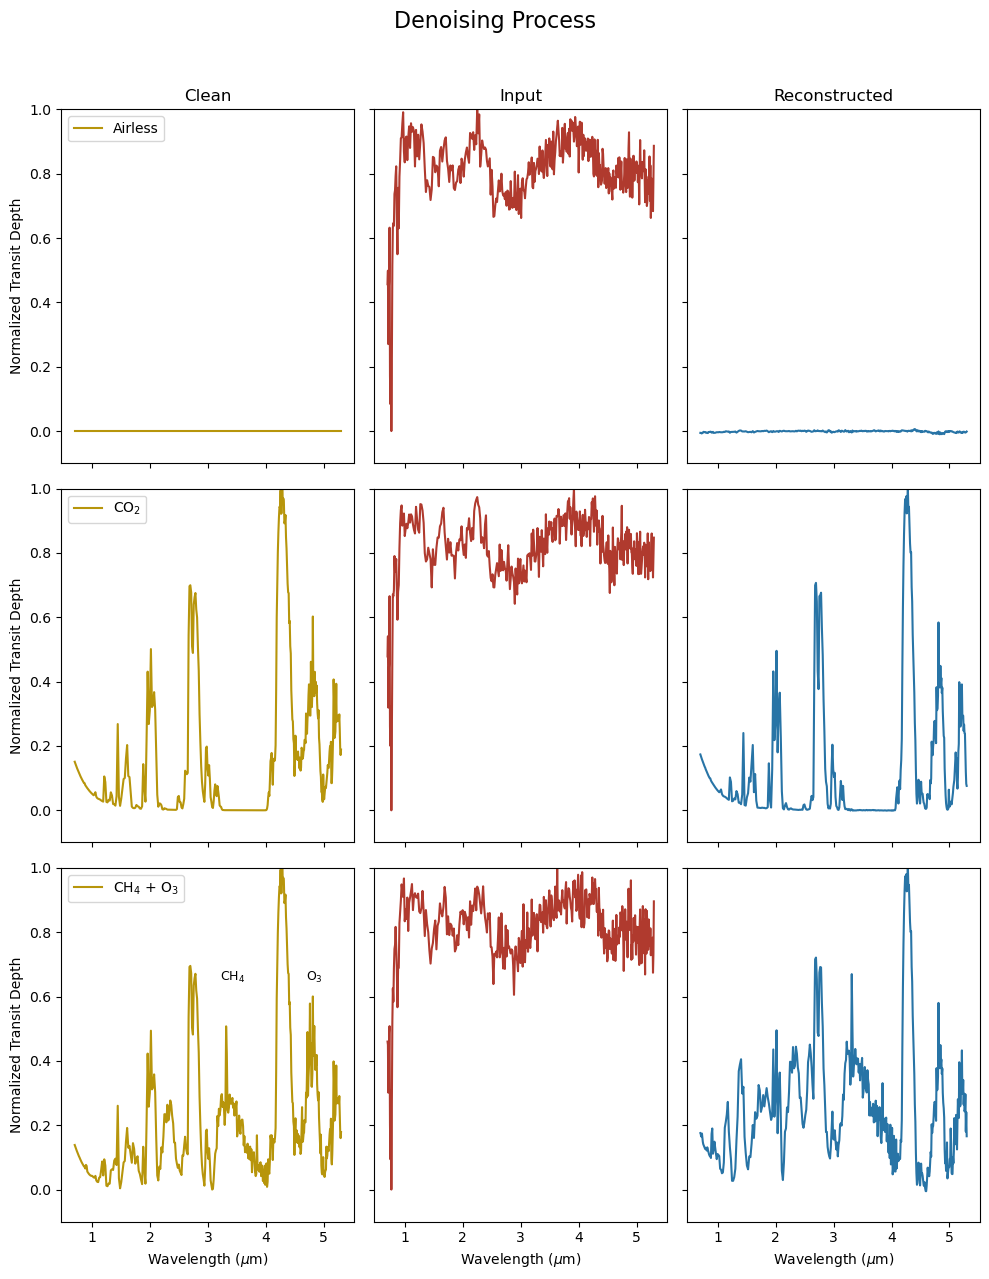

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for the spectra
clean_color = "#B7950B"  # CH4 base color
input_color = "#B03A2E"  # O3 base color
reconstructed_color = "#2874A6"  # H2O base color

num_samples = 3
indices = [0, 1, 2]
labels = ["Airless", "CO$_2$", "CH$_4$ + O$_3$"]
# Create subplots
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 13), sharex=True, sharey=True)
fig.suptitle('Denoising Process', fontsize=16)

# Column titles
columns = ['Clean', 'Input', 'Reconstructed']

# Plot the spectra
for i, idx in enumerate(indices):
    # Clean Spectrum
    axes[i, 0].plot(waves[::-1], X_clean[idx], color=clean_color,
                    label =  labels[i])
    axes[i, 0].set_ylim(-0.1, 1)
    axes[i, 0].set_title(columns[0] if i == 0 else None)
    axes[i, 0].set_ylabel('Normalized Transit Depth')
    axes[i, 0].legend(loc='upper left')
    if i == 2:
        axes[i, 0].text(3.2, 0.65, 'CH$_4$', fontsize=9, color='black')
        axes[i, 0].text(4.7, 0.65, 'O$_3$', fontsize=9, color='black')
    axes[i, 0].legend(loc='upper left')
    
    
    # Input Spectrum
    axes[i, 1].plot(waves[::-1], X_noisy[idx], color=input_color)
    axes[i, 1].set_ylim(-0.1, 1)
    axes[i, 1].set_title(columns[1] if i == 0 else None)
    
    # Reconstructed Spectrum
    axes[i, 2].plot(waves[::-1], X_reconstructed[idx], color=reconstructed_color)
    axes[i, 2].set_ylim(-0.1, 1)
    axes[i, 2].set_title(columns[2] if i == 0 else None)

# X-axis label
for ax in axes[-1, :]:
    ax.set_xlabel('Wavelength ($\mu$m)')

plt.tight_layout(rect=[0, 0, 1, 0.96])

## save as .svg file
#plt.savefig('fotos/autoencoder.svg', format='svg', dpi=300)
plt.show()




### SNR = 6

In [18]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=6     
)["noise"][1]

SNR6_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR6_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=100,
    noise_std = noise     
)

SNR6_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR6_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=3,
    noise_std = noise
)
    
SNR6_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR6_df = pd.concat(
    [
        SNR6_CO2_data,
        SNR6_CH4_data,
        SNR6_O3_data,
        SNR6_H2O_data,
        SNR6_CH4_O3_data,
        SNR6_CH4_H2O_data,
        SNR6_O3_H2O_data,
        SNR6_CH4_O3_H2O_data,
        SNR6_airless_data
    ],
    ignore_index=True
) 


del (
        SNR6_CO2_data,
        SNR6_CH4_data,
        SNR6_O3_data,
        SNR6_H2O_data,
        SNR6_CH4_O3_data,
        SNR6_CH4_H2O_data,
        SNR6_O3_H2O_data,
        SNR6_CH4_O3_H2O_data,
        SNR6_airless_data
        
)

gc.collect()


28523

### SNR = 10

In [19]:
noise =  mrex.generate_df_SNR_noise(
    df=CO2_data,
    n_repeat=1,
    SNR=10     
)["noise"][1]

SNR10_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = noise     
)

SNR10_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=100,
    noise_std = noise    
)

SNR10_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=20,
    noise_std = noise
)

SNR10_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=3,
    noise_std = noise
)
  
SNR10_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = noise   
)

SNR10_df = pd.concat(
    [
        SNR10_CO2_data,
        SNR10_CH4_data,
        SNR10_O3_data,
        SNR10_H2O_data,
        SNR10_CH4_O3_data,
        SNR10_CH4_H2O_data,
        SNR10_O3_H2O_data,
        SNR10_CH4_O3_H2O_data,
        SNR10_airless_data
    ],
    ignore_index=True
) 

del (
        SNR10_CO2_data,
        SNR10_CH4_data,
        SNR10_O3_data,
        SNR10_H2O_data,
        SNR10_CH4_O3_data,
        SNR10_CH4_H2O_data,
        SNR10_O3_H2O_data,
        SNR10_CH4_O3_H2O_data,
        SNR10_airless_data
        
)

gc.collect()

0

### SNR = NaN

In [20]:
SNRnan_CO2_data = generate_df_with_noise_std(
    df=CO2_data,
    n_repeat=10_000,
    noise_std = 0     
)

SNRnan_CH4_data = generate_df_with_noise_std(
    df=CH4_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_O3_data = generate_df_with_noise_std(
    df=O3_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_H2O_data = generate_df_with_noise_std(
    df=H2O_data,
    n_repeat=250,
    noise_std = 0     
)

SNRnan_CH4_O3_data = generate_df_with_noise_std(
    df=CH4_O3_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_CH4_H2O_data = generate_df_with_noise_std(
    df=CH4_H2O_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_O3_H2O_data = generate_df_with_noise_std(
    df=O3_H2O_data,
    n_repeat=50,
    noise_std = 0
)

SNRnan_CH4_O3_H2O_data = generate_df_with_noise_std(
    df=CH4_O3_H2O_data,
    n_repeat=5,
    noise_std = 0
)
    
SNRnan_airless_data = generate_df_with_noise_std(
    df=airless_data,
    n_repeat=10_000,
    noise_std = 0
)

SNRnan_df = pd.concat(
    [
        SNRnan_CO2_data,
        SNRnan_CH4_data,
        SNRnan_O3_data,
        SNRnan_H2O_data,
        SNRnan_CH4_O3_data,
        SNRnan_CH4_H2O_data,
        SNRnan_O3_H2O_data,
        SNRnan_CH4_O3_H2O_data
    ],
    ignore_index=True
) 

del (
        SNRnan_CO2_data,
        SNRnan_CH4_data,
        SNRnan_O3_data,
        SNRnan_H2O_data,
        SNRnan_CH4_O3_data,
        SNRnan_CH4_H2O_data,
        SNRnan_O3_H2O_data,
        SNRnan_CH4_O3_H2O_data
        
)

gc.collect()

0

In [21]:
SNRall= pd.concat([SNR1_df,SNR3_df,SNR6_df,SNR10_df,SNRnan_df],ignore_index=True)
SNRall_train, SNRall_test = train_test_split(SNRall, test_size=0.2)
del SNRall 
gc.collect()
## normalize 
SNRall_train.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_train.iloc[:,-n_points:])
SNRall_test.iloc[:,-n_points:]=normalize_min_max_by_row(SNRall_test.iloc[:,-n_points:])

SNRall_X_train = SNRall_train.iloc[:,-n_points:]
SNRall_Y_train = np.array(SNRall_train["label"].tolist())

SNRall_X_test = SNRall_test.iloc[:,-n_points:]
SNRall_Y_test = np.array(SNRall_test["label"].tolist())

## Random Forest

In [22]:
from tensorflow import keras 

encoder = keras.models.load_model("AE.keras")

SNRall_X_train = encoder.predict(SNRall_X_train)

SNRall_X_test = encoder.predict(SNRall_X_test)

109624/109624 ━━━━━━━━━━━━━━━━━━━━ 1089s 10ms/step
27406/27406 ━━━━━━━━━━━━━━━━━━━━ 128s 5ms/step


In [23]:
rf= RandomForestClassifier(n_estimators=100,
                           criterion= "entropy",
                           min_samples_leaf= 3,
                           n_jobs=-1,
                           )

rf.fit(SNRall_X_train,SNRall_Y_train) 

import joblib
joblib.dump(rf, "BC_RF.joblib")

['BC_RF.joblib']

In [24]:
""" import joblib
rf = joblib.load("BC_RF.joblib")

from tensorflow import keras 

encoder = keras.models.load_model("autoencoder.keras") """

' import joblib\nrf = joblib.load("BC_RF.joblib")\n\nfrom tensorflow import keras \n\nencoder = keras.models.load_model("autoencoder.keras") '

## Test for SNR

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import gc
import pickle
from sklearn.metrics import (
    f1_score, recall_score, precision_score, confusion_matrix
)
from tqdm import tqdm

# Parameters and helper functions
SNRS = [1, 2, 3, 4, 5, 7, 10]
f_spot_values = [0, 0.01, 0.08, 0.26]  # same stellar contamination levels
f_fac_values = [0, 0.08, 0.54, 0.70]
mix_ratios = np.logspace(-8, -1, 8)


def filter_data(df, f_spot_val, f_fac_val):
    """Filter DataFrame by f_spot and f_fac values."""
    return df[(df["f_spot"] == f_spot_val) & (df["f_fac"] == f_fac_val)]


# Structures for storing results
all_results = {}
factor = 10 / 8
total_combinations = len(f_spot_values) * len(f_fac_values)

with tqdm(total=total_combinations,
          desc="Processing f_spot and f_fac combos") as pbar_combos:
    for f_spot_val in f_spot_values:
        for f_fac_val in f_fac_values:
            # Skip invalid combinations: (0, non-zero) or (non-zero, 0) except (0, 0)
            if (f_spot_val == 0 and f_fac_val != 0) or (
                f_spot_val != 0 and f_fac_val == 0
            ):
                pbar_combos.update(1)
                continue

            # Initialize result dictionaries for this combination
            mol_SNR_scores = {"SNR": [], "min_mix_ratio": [[], []]}  # [CH4, O3]
            global_SNR_scores = {
                "SNR": [],
                "f1": [],
                "recall": [],
                "precision": [],
                "TNR": []
            }

            for SNR in tqdm(SNRS,
                            desc=f"f_spot={f_spot_val}, f_fac={f_fac_val}",
                            leave=False):
                # Generate noise
                noise = mrex.generate_df_SNR_noise(
                    df=CO2_data, n_repeat=1, SNR=SNR
                )["noise"][1]

                # Generate noisy data for each dataset
                SNR_test_CO2_data = generate_df_with_noise_std(
                    df=CO2_data, n_repeat=5000, noise_std=noise
                )
                SNR_test_CH4_data = generate_df_with_noise_std(
                    df=CH4_data, n_repeat=int(250 * factor), noise_std=noise
                )
                SNR_test_O3_data = generate_df_with_noise_std(
                    df=O3_data, n_repeat=int(250 * factor), noise_std=noise
                )
                SNR_test_H2O_data = generate_df_with_noise_std(
                    df=H2O_data, n_repeat=int(500 * factor), noise_std=noise
                )
                SNR_test_CH4_O3_data = generate_df_with_noise_std(
                    df=CH4_O3_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_CH4_H2O_data = generate_df_with_noise_std(
                    df=CH4_H2O_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_O3_H2O_data = generate_df_with_noise_std(
                    df=O3_H2O_data,
                    n_repeat=int(25 * factor * factor),
                    noise_std=noise
                )
                SNR_test_CH4_O3_H2O_data = generate_df_with_noise_std(
                    df=CH4_O3_H2O_data,
                    n_repeat=int(2.5 * factor * factor * factor),
                    noise_std=noise
                )
                SNR_test_airless_data = generate_df_with_noise_std(
                    df=airless_data, n_repeat=5000 * 3, noise_std=noise
                )

                # Concatenate all generated DataFrames
                SNR_test_df = pd.concat(
                    [
                        SNR_test_CO2_data,
                        SNR_test_CH4_data,
                        SNR_test_O3_data,
                        SNR_test_H2O_data,
                        SNR_test_CH4_O3_data,
                        SNR_test_CH4_H2O_data,
                        SNR_test_O3_H2O_data,
                        SNR_test_CH4_O3_H2O_data,
                        SNR_test_airless_data,
                    ],
                    ignore_index=True
                )

                # Free memory
                del (SNR_test_CO2_data, SNR_test_CH4_data,
                     SNR_test_O3_data, SNR_test_H2O_data,
                     SNR_test_CH4_O3_data, SNR_test_CH4_H2O_data,
                     SNR_test_O3_H2O_data, SNR_test_CH4_O3_H2O_data,
                     SNR_test_airless_data)
                gc.collect()

                # Filter DataFrame by f_spot and f_fac values
                SNR_test_df = filter_data(SNR_test_df, f_spot_val, f_fac_val)
                if SNR_test_df.empty:
                    continue

                SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
                    SNR_test_df.iloc[:, -n_points:]
                )
                SNR_X_test = SNR_test_df.iloc[:, -n_points:]
                SNR_X_test = encoder.predict(SNR_X_test)

                # Binary model prediction (assumes 'label' is binary)
                probabilities = rf.predict_proba(SNR_X_test)[:, 1]
                threshold = 0.45
                y_pred = (probabilities > threshold).astype(int)
                SNR_test_df["pred"] = y_pred
                SNR_test_df["score"] = probabilities
                y_true = SNR_test_df["label"].astype(int)

                # Compute global metrics
                global_SNR_scores["SNR"].append(SNR)
                global_SNR_scores["f1"].append(f1_score(y_true, y_pred))
                global_SNR_scores["recall"].append(recall_score(y_true, y_pred))
                global_SNR_scores["precision"].append(
                    precision_score(y_true, y_pred)
                )
                # True Negative Rate (TNR)
                global_SNR_scores["TNR"].append(
                    recall_score(y_true, y_pred, pos_label=0)
                )

                # Calculate minimum mixing ratio for CH4 and O3
                CH4_SNR_test_by_atmCH4 = [[] for _ in range(len(mix_ratios))]
                O3_SNR_test_by_atmO3 = [[] for _ in range(len(mix_ratios))]

                for i, j in enumerate(range(-8, 0)):
                    CH4_SNR_test_by_atmCH4[i] = SNR_test_df[
                        SNR_test_df["atm CH4"] == j
                    ]
                    co2 = int(len(SNR_test_df[SNR_test_df["label"] == 0]) / 8)
                    no_CH4 = SNR_test_df[SNR_test_df["label"] == 0].sample(co2)
                    CH4_SNR_test_by_atmCH4[i] = pd.concat(
                        [CH4_SNR_test_by_atmCH4[i], no_CH4]
                    )

                    O3_SNR_test_by_atmO3[i] = SNR_test_df[
                        SNR_test_df["atm O3"] == j
                    ]
                    co2 = int(len(SNR_test_df[SNR_test_df["label"] == 0]) / 8)
                    no_O3 = SNR_test_df[SNR_test_df["label"] == 0].sample(co2)
                    O3_SNR_test_by_atmO3[i] = pd.concat(
                        [O3_SNR_test_by_atmO3[i], no_O3]
                    )

                CH4_SNR_recall = np.zeros(len(mix_ratios))
                O3_SNR_recall = np.zeros(len(mix_ratios))

                # Compute recall for each mix ratio for CH4 and O3
                for m_idx in range(len(mix_ratios)):
                    # CH4 recall
                    CH4_labels = CH4_SNR_test_by_atmCH4[m_idx]["label"]\
                        .astype(int)
                    CH4_preds = CH4_SNR_test_by_atmCH4[m_idx]["pred"]\
                        .astype(int)
                    CH4_SNR_recall[m_idx] = recall_score(CH4_labels, CH4_preds)

                    # O3 recall
                    O3_labels = O3_SNR_test_by_atmO3[m_idx]["label"]\
                        .astype(int)
                    O3_preds = O3_SNR_test_by_atmO3[m_idx]["pred"]\
                        .astype(int)
                    O3_SNR_recall[m_idx] = recall_score(O3_labels, O3_preds)

                # Determine min_mix_ratio (first mix ratio with recall > 0.6)
                CH4_min_mix_ratio = mix_ratios[
                    np.where(CH4_SNR_recall > 0.6)
                ][0] if np.any(CH4_SNR_recall >= 0.6) else 1
                O3_min_mix_ratio = mix_ratios[
                    np.where(O3_SNR_recall > 0.6)
                ][0] if np.any(O3_SNR_recall >= 0.6) else 1

                mol_SNR_scores["SNR"].append(SNR)
                mol_SNR_scores["min_mix_ratio"][0].append(CH4_min_mix_ratio)
                mol_SNR_scores["min_mix_ratio"][1].append(O3_min_mix_ratio)

            # Store results for the current combination
            all_results[(f_spot_val, f_fac_val)] = {
                "global_SNR_scores": global_SNR_scores,
                "mol_SNR_scores": mol_SNR_scores,
            }
            pbar_combos.update(1)

Processing f_spot and f_fac combos:   0%|          | 0/16 [00:00<?, ?it/s]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:   6%|▋         | 1/16 [03:39<54:51, 219.43s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  38%|███▊      | 6/16 [07:02<10:25, 62.51s/it] 

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  44%|████▍     | 7/16 [10:24<13:34, 90.50s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  50%|█████     | 8/16 [13:46<15:22, 115.35s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  62%|██████▎   | 10/16 [17:08<10:58, 109.80s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  69%|██████▉   | 11/16 [20:30<10:49, 129.89s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  75%|███████▌  | 12/16 [23:52<09:48, 147.00s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  88%|████████▊ | 14/16 [27:14<04:16, 128.42s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos:  94%|█████████▍| 15/16 [30:36<02:24, 144.87s/it]

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


Processing f_spot and f_fac combos: 100%|██████████| 16/16 [33:58<00:00, 127.43s/it]


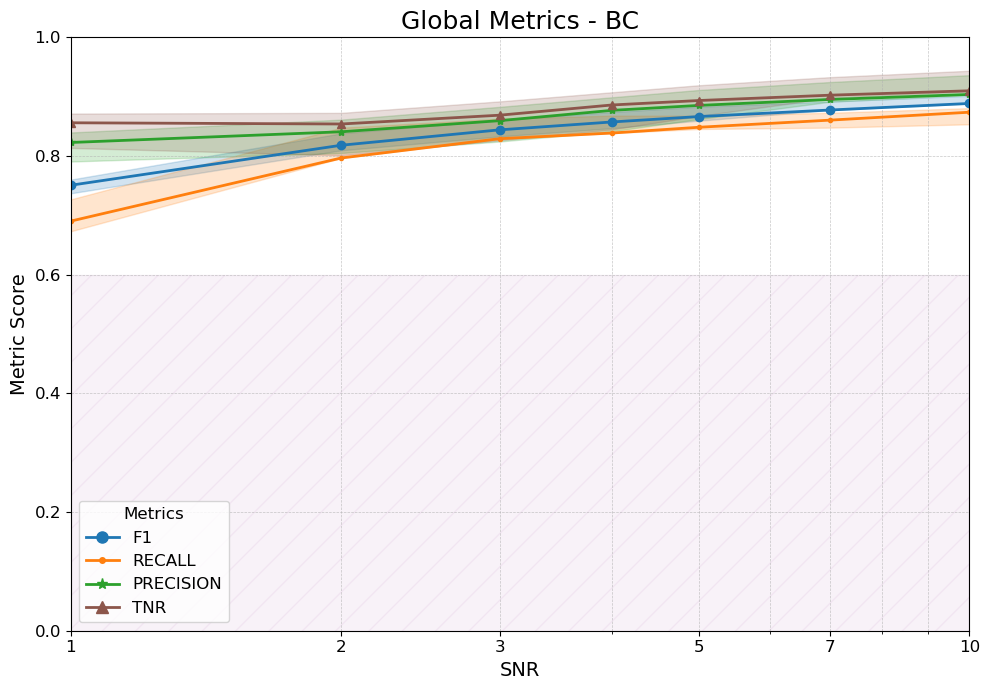

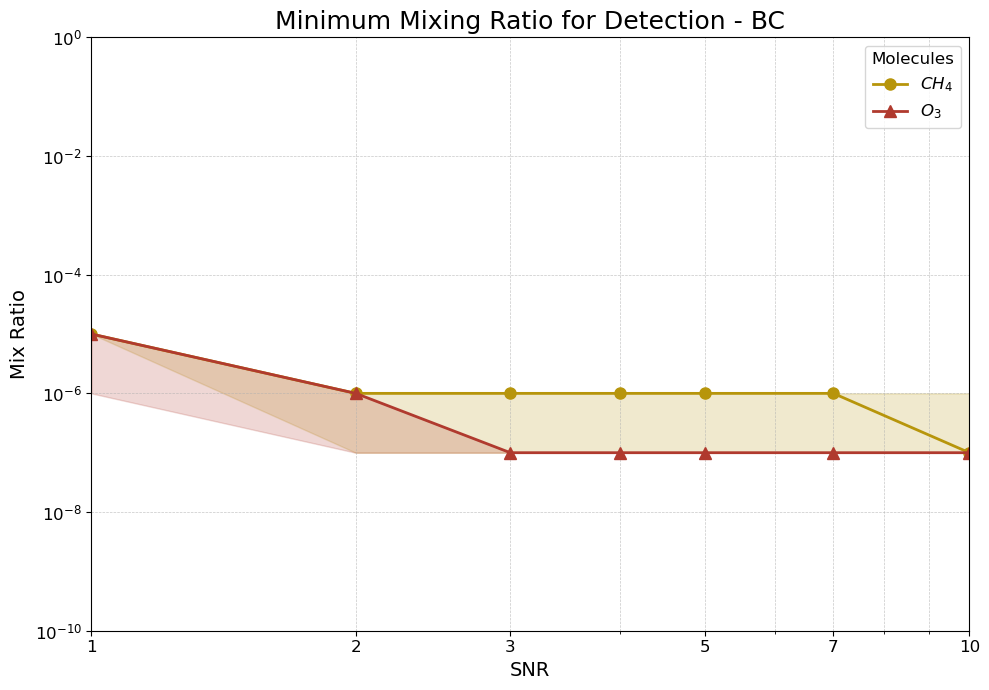

In [26]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from collections import OrderedDict

# Base parameters
f_spot_values = [0, 0.01, 0.08, 0.26]
f_fac_values = [0, 0.08, 0.54, 0.70]
base_f_spot = 0
base_f_fac = 0


def adjust_color_lightness(color, amount=0.7):
    """Adjust the lightness of a color."""
    try:
        c = mcolors.to_rgb(color)
    except ValueError:
        c = (0.5, 0.5, 0.5)
    return [min(1, max(0, channel * amount)) for channel in c]


alpha = 0.5
lf = 0.7

# Colors and markers for global metrics
global_metrics_colors = {
    "f1": "#1f77b4",
    "recall": "#ff7f0e",
    "precision": "#2ca02c",
    "TNR": "#8c564b"
}

global_metrics_markers = {
    "f1": "o",
    "recall": ".",
    "precision": "*",
    "TNR": "^"
}

# Base case results
base_global = all_results[(base_f_spot, base_f_fac)]["global_SNR_scores"]
base_mol = all_results[(base_f_spot, base_f_fac)]["mol_SNR_scores"]


def get_min_max_global(metric, snrs):
    """Calculate min and max for a global metric over SNRs."""
    mins = []
    maxs = []
    for snr in snrs:
        values = []
        for (fsp, ffac), results in all_results.items():
            if snr in results["global_SNR_scores"]["SNR"]:
                idx = results["global_SNR_scores"]["SNR"].index(snr)
                if metric == "1_hamming_loss":
                    val = 1 - results["global_SNR_scores"]["hamming_loss"][idx]
                else:
                    val = results["global_SNR_scores"][metric][idx]
                values.append(val)
        if values:
            mins.append(min(values))
            maxs.append(max(values))
        else:
            base_val = base_global[metric][base_global["SNR"].index(snr)]
            mins.append(base_val)
            maxs.append(base_val)
    return np.array(mins), np.array(maxs)


def get_min_max_mol(metric, mol_idx, snrs):
    """Calculate min and max for a molecular metric over SNRs."""
    mins = []
    maxs = []
    for snr in snrs:
        values = []
        for (fsp, ffac), results in all_results.items():
            idx = results["mol_SNR_scores"]["SNR"].index(snr)
            val = results["mol_SNR_scores"][metric][mol_idx][idx]
            values.append(val)
        if values:
            mins.append(min(values))
            maxs.append(max(values))
        else:
            base_val = base_mol[metric][mol_idx][
                base_mol["SNR"].index(snr)
            ]
            mins.append(base_val)
            maxs.append(base_val)
    return np.array(mins), np.array(maxs)


# Plot global metrics with shaded area
plt.figure(figsize=(10, 7))
snrs = base_global["SNR"]

# Plot shaded area (min-max) for each metric
for metric, color in global_metrics_colors.items():
    min_vals, max_vals = get_min_max_global(metric, snrs)
    plt.fill_between(snrs, min_vals, max_vals, color=color, alpha=0.2)

# Plot base case with labels
for metric, color in global_metrics_colors.items():
    plt.plot(
        snrs,
        base_global[metric],
        label=f"{metric.upper()} (base)",
        marker=global_metrics_markers[metric],
        color=color,
        linewidth=2,
        alpha=1.0,
    )

plt.ylim(0, 1)
plt.xscale("log")
plt.xlabel("SNR", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.title("Global Metrics - BC", fontsize=18)
plt.xticks([1, 2, 3, 5, 7, 10], ["1", "2", "3", "5", "7", "10"])
plt.xlim(1, 10)
plt.gca().get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.gca().get_xaxis().set_minor_formatter(ticker.NullFormatter())
plt.tick_params(axis="both", which="major", labelsize=12)

# Shaded area below 0.6 for low performance
plt.fill_between(snrs, 0, 0.6, hatch="/", color="purple", alpha=0.05)

# Create legend handles
handles = [
    Line2D(
        [0],
        [0],
        color=global_metrics_colors[metric],
        marker=global_metrics_markers[metric],
        linestyle="-",
        linewidth=2,
        markersize=8,
        label=f"{metric.upper()}",
    )
    for metric in global_metrics_colors.keys()
]
plt.legend(
    handles=handles,
    title="Metrics",
    fontsize=12,
    title_fontsize=12,
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
#plt.savefig("fotos/auto-BC-globalmetrics.svg", dpi=300)
plt.show()

# Plot minimum mixing ratio (CH4 and O3) with shaded areas
ch4_base_color = "#B7950B"
o3_base_color = "#B03A2E"

plt.figure(figsize=(10, 7))
snrs = base_mol["SNR"]

# Calculate min-max ranges for CH4 and O3
min_ch4, max_ch4 = get_min_max_mol("min_mix_ratio", 0, snrs)
min_o3, max_o3 = get_min_max_mol("min_mix_ratio", 1, snrs)

# Plot shaded areas
plt.fill_between(snrs, min_ch4, max_ch4, color=ch4_base_color, alpha=0.2)
plt.fill_between(snrs, min_o3, max_o3, color=o3_base_color, alpha=0.2)

# Plot base case for CH4 and O3
plt.plot(
    snrs,
    base_mol["min_mix_ratio"][0],
    "-o",
    label="$CH_4$ (base)",
    color=ch4_base_color,
    markersize=8,
    linewidth=2,
)
plt.plot(
    snrs,
    base_mol["min_mix_ratio"][1],
    "-^",
    label="$O_3$ (base)",
    color=o3_base_color,
    markersize=8,
    linewidth=2,
)

plt.xscale("log")
plt.xlabel("SNR", fontsize=14)
plt.ylabel("Mix Ratio", fontsize=14)
plt.title("Minimum Mixing Ratio for Detection - BC", fontsize=18)
plt.xticks([1, 2, 3, 5, 7, 10], ["1", "2", "3", "5", "7", "10"])
plt.xlim(1, 10)
plt.ylim(1e-10, 1)
plt.yscale("log")
plt.gca().get_xaxis().set_major_formatter(ticker.ScalarFormatter())
plt.gca().get_xaxis().set_minor_formatter(ticker.NullFormatter())
plt.tick_params(axis="both", which="major", labelsize=12)

# Create legend handles for molecules
handles = [
    Line2D(
        [0],
        [0],
        color=ch4_base_color,
        marker="o",
        linestyle="-",
        linewidth=2,
        markersize=8,
        label="$CH_4$",
    ),
    Line2D(
        [0],
        [0],
        color=o3_base_color,
        marker="^",
        linestyle="-",
        linewidth=2,
        markersize=8,
        label="$O_3$",
    ),
]
plt.legend(
    handles=handles,
    title="Molecules",
    fontsize=12,
    title_fontsize=12,
)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
#plt.savefig("fotos/auto-BC-minmix.svg", dpi=300)
plt.show()

## Validation vs other molecules


SNR=2
32423/32423 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_8988\2083938285.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=5, w_pad=5)


SNR=10
32423/32423 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step


C:\Users\User\AppData\Local\Temp\ipykernel_8988\2083938285.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=5, w_pad=5)
C:\Users\User\AppData\Local\Temp\ipykernel_8988\2083938285.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=2, w_pad=3)


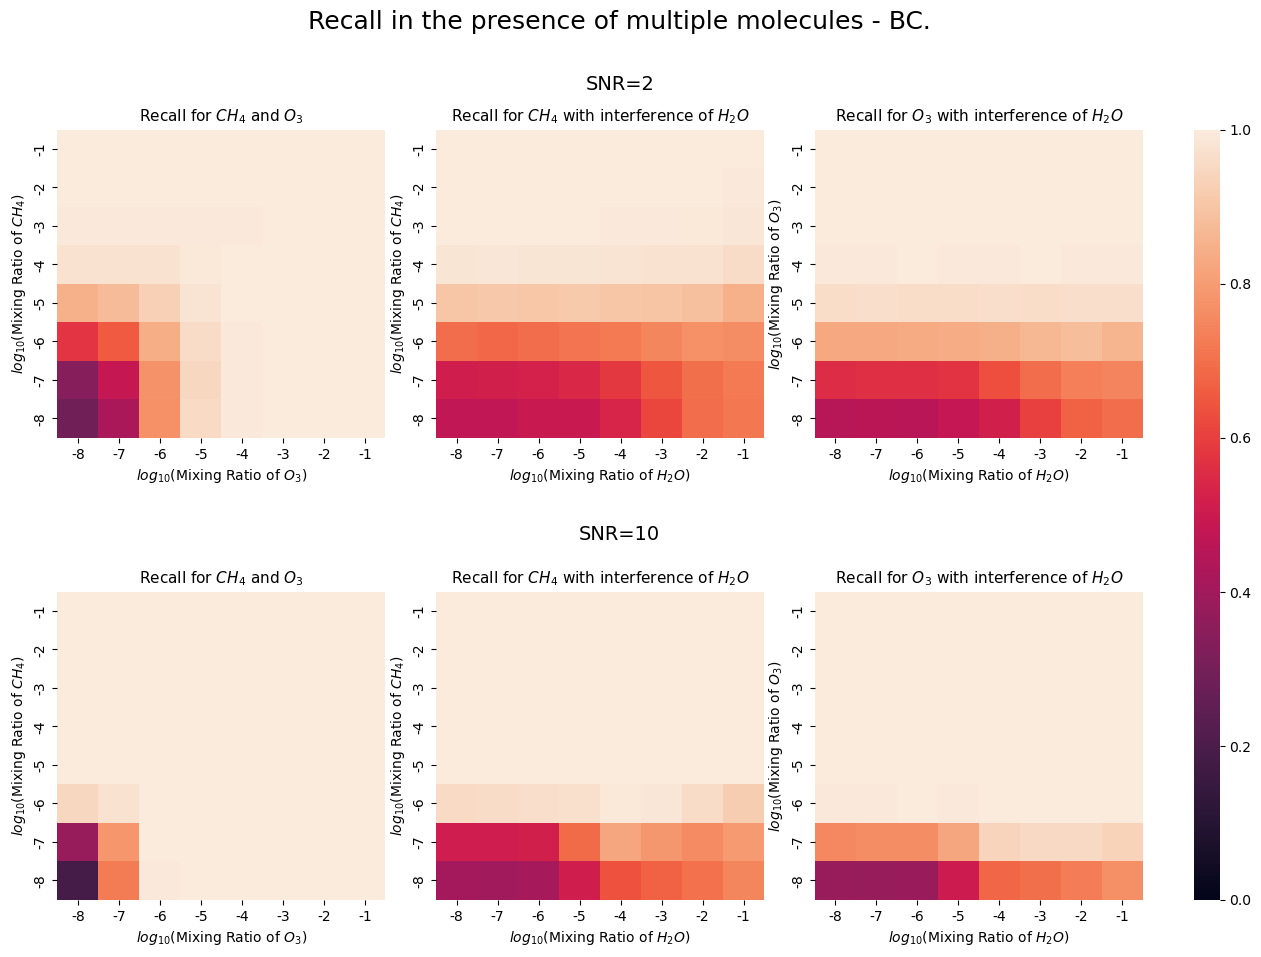

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import gc
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
import seaborn as sns

# Define SNRs for analysis
SNRS = [2, 10]

# Create figure with GridSpec layout
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.08], wspace=0.2, hspace=0.5)

factor = 10 / 8

for aj, SNR in enumerate(SNRS):
    print(f"SNR={SNR}")

    # Generate noise for current SNR
    noise = mrex.generate_df_SNR_noise(
        df=CO2_data, n_repeat=1, SNR=SNR
    )["noise"][1]

    # Generate noisy data for different gases
    SNR_test_CH4_data = generate_df_with_noise_std(
        df=CH4_data,
        n_repeat=int(500 * factor),
        noise_std=noise
    )
    SNR_test_O3_data = generate_df_with_noise_std(
        df=O3_data,
        n_repeat=int(500 * factor),
        noise_std=noise
    )
    SNR_test_H2O_data = generate_df_with_noise_std(
        df=H2O_data,
        n_repeat=int(500 * factor),
        noise_std=noise
    )
    SNR_test_CH4_O3_data = generate_df_with_noise_std(
        df=CH4_O3_data,
        n_repeat=int(50 * factor * factor),
        noise_std=noise
    )
    SNR_test_CH4_H2O_data = generate_df_with_noise_std(
        df=CH4_H2O_data,
        n_repeat=int(50 * factor * factor),
        noise_std=noise
    )
    SNR_test_O3_H2O_data = generate_df_with_noise_std(
        df=O3_H2O_data,
        n_repeat=int(50 * factor * factor),
        noise_std=noise
    )
    SNR_test_CH4_O3_H2O_data = generate_df_with_noise_std(
        df=CH4_O3_H2O_data,
        n_repeat=int(5 * factor * factor * factor),
        noise_std=noise
    )

    # Concatenate all generated data
    SNR_test_df = pd.concat(
        [
            SNR_test_CH4_data,
            SNR_test_O3_data,
            SNR_test_H2O_data,
            SNR_test_CH4_O3_data,
            SNR_test_CH4_H2O_data,
            SNR_test_O3_H2O_data,
            SNR_test_CH4_O3_H2O_data,
        ],
        ignore_index=True
    )

    del (SNR_test_CH4_data, SNR_test_O3_data, SNR_test_H2O_data,
         SNR_test_CH4_O3_data, SNR_test_CH4_H2O_data,
         SNR_test_O3_H2O_data, SNR_test_CH4_O3_H2O_data)
    gc.collect()

    # Normalize and encode data
    SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
        SNR_test_df.iloc[:, -n_points:]
    )
    SNR_X_test = encoder.predict(SNR_test_df.iloc[:, -n_points:])
    SNR_test = SNR_test_df["label"]

    SNR_test_df["label"] = SNR_test_df["label"].astype(int)

    # Predict probabilities and assign labels
    probabilities = rf.predict_proba(SNR_X_test)[:, 1]
    threshold = 0.45
    y_pred = (probabilities > threshold).astype(int)
    SNR_test_df["pred"] = y_pred

    # Initialize arrays for recall scores
    si_CH4_sO3 = np.zeros((8, 8))
    si_CH4_sH2O = np.zeros((8, 8))
    si_O3_sH2O = np.zeros((8, 8))

    for i, mix1 in enumerate(range(-8, 0)):
        for j, mix2 in enumerate(range(-8, 0)):
            # Recall for CH4 and O3
            permix_si_CH4_sO3 = SNR_test_df[
                (SNR_test_df["atm O3"] == mix2) &
                (SNR_test_df["atm CH4"] == mix1)
            ]
            # Recall for CH4 with H2O interference
            permix_si_CH4_sH2O = SNR_test_df[
                (SNR_test_df["atm H2O"] == mix2) &
                (SNR_test_df["atm CH4"] == mix1)
            ]
            # Recall for O3 with H2O interference
            permix_si_O3_sH2O = SNR_test_df[
                (SNR_test_df["atm H2O"] == mix2) &
                (SNR_test_df["atm O3"] == mix1)
            ]
            si_CH4_sO3[i, j] = accuracy_score(
                permix_si_CH4_sO3["label"],
                permix_si_CH4_sO3["pred"]
            )
            si_CH4_sH2O[i, j] = accuracy_score(
                permix_si_CH4_sH2O["label"],
                permix_si_CH4_sH2O["pred"]
            )
            si_O3_sH2O[i, j] = accuracy_score(
                permix_si_O3_sH2O["label"],
                permix_si_O3_sH2O["pred"]
            )

    log_ratios = np.arange(-8, 0, 1)

    # Create heatmap for CH4 and O3 recall
    ax1 = fig.add_subplot(gs[aj, 0])
    sns.heatmap(
        si_CH4_sO3, ax=ax1, vmin=0, vmax=1,
        xticklabels=log_ratios, yticklabels=log_ratios,
        cbar=False
    )
    ax1.set_title("Recall for $CH_4$ and $O_3$", fontsize=11)
    ax1.set_xlabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax1.set_ylabel("$log_{10}$(Mixing Ratio of $CH_4$)")
    ax1.invert_yaxis()

    # Create heatmap for CH4 with H2O interference
    ax2 = fig.add_subplot(gs[aj, 1])
    sns.heatmap(
        si_CH4_sH2O, ax=ax2, vmin=0, vmax=1,
        xticklabels=log_ratios, yticklabels=log_ratios,
        cbar=False
    )
    ax2.set_title("Recall for $CH_4$ with interference of $H_2O$",
                  fontsize=11)
    ax2.set_xlabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax2.set_ylabel("$log_{10}$(Mixing Ratio of $CH_4$)")
    ax2.invert_yaxis()

    # Create heatmap for O3 with H2O interference
    ax3 = fig.add_subplot(gs[aj, 2])
    if aj == 0:
        cbar_ax1 = fig.add_subplot(gs[:, 3])
        sns.heatmap(
            si_O3_sH2O, ax=ax3, vmin=0, vmax=1,
            xticklabels=log_ratios, yticklabels=log_ratios,
            cbar_ax=cbar_ax1
        )
    else:
        sns.heatmap(
            si_O3_sH2O, ax=ax3, vmin=0, vmax=1,
            xticklabels=log_ratios, yticklabels=log_ratios,
            cbar=False
        )
    ax3.set_title("Recall for $O_3$ with interference of $H_2O$",
                  fontsize=11)
    ax3.set_xlabel("$log_{10}$(Mixing Ratio of $H_2O$)")
    ax3.set_ylabel("$log_{10}$(Mixing Ratio of $O_3$)")
    ax3.invert_yaxis()

    # Add subtitle for each SNR
    fig.text(0.5, 0.92 - (aj * 0.45), f"SNR={SNR}",
             ha="center", fontsize=14)
    plt.tight_layout(h_pad=5, w_pad=5)

plt.tight_layout(h_pad=2, w_pad=3)
plt.suptitle("Recall in the presence of multiple molecules - BC.",
             fontsize=18, y=1)
#plt.savefig("fotos/auto-BC_RecallMap_SNR.svg", dpi=300)
plt.show()


Processing SNR=1
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Processing SNR=3
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Processing SNR=5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step
Processing SNR=7
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step


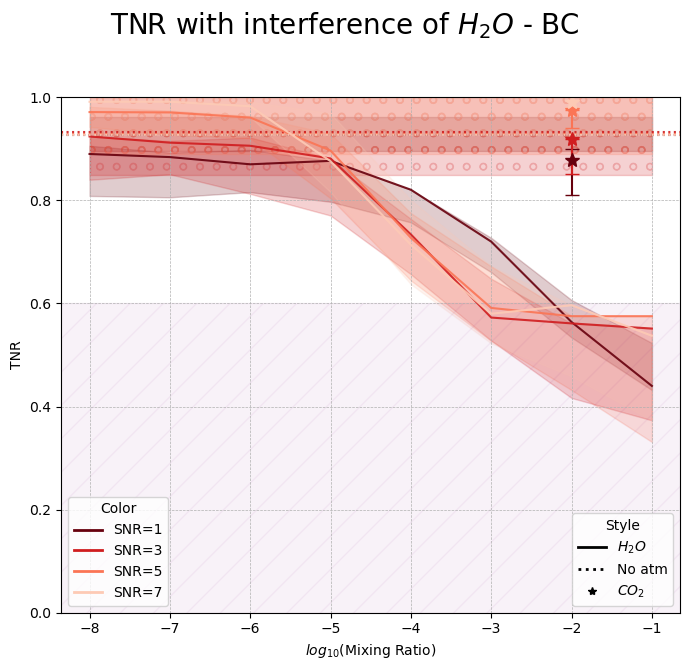

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import gc
from sklearn.metrics import recall_score
from tqdm import tqdm
from matplotlib.lines import Line2D

# Parameters and helper functions
SNRS = [1, 3, 5, 7]
f_spot_values = [0, 0.01, 0.08, 0.26]  # Stellar contaminations
f_fac_values = [0, 0.08, 0.54, 0.70]
mix_ratios = np.linspace(-8, -1, 8)
reds = plt.cm.Reds(np.linspace(1, 0.2, len(SNRS)))


def filter_data(df, f_spot_val, f_fac_val):
    """Filter data by f_spot and f_fac values."""
    return df[(df["f_spot"] == f_spot_val) &
              (df["f_fac"] == f_fac_val)]


all_results = {}

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
factor = 10 / 8

for idx, SNR in enumerate(SNRS):
    print(f"Processing SNR={SNR}")

    noise = mrex.generate_df_SNR_noise(
        df=CO2_data,
        n_repeat=1,
        SNR=SNR
    )["noise"][1]

    SNR_test_CO2_data = generate_df_with_noise_std(
        df=CO2_data,
        n_repeat=5000,
        noise_std=noise
    )
    SNR_test_noatm_data = generate_df_with_noise_std(
        df=airless_data,
        n_repeat=5000,
        noise_std=noise
    )
    SNR_test_H2O_data = generate_df_with_noise_std(
        df=H2O_data,
        n_repeat=500,
        noise_std=noise
    )

    SNR_test_df = pd.concat(
        [SNR_test_CO2_data, SNR_test_H2O_data, SNR_test_noatm_data],
        ignore_index=True
    )

    del (SNR_test_CO2_data, SNR_test_H2O_data, SNR_test_noatm_data)
    gc.collect()

    SNR_test_df.iloc[:, -n_points:] = normalize_min_max_by_row(
        SNR_test_df.iloc[:, -n_points:]
    )
    SNR_X_test = encoder.predict(SNR_test_df.iloc[:, -n_points:])
    SNR_test_df["label"] = SNR_test_df["label"].astype(int)

    probabilities = rf.predict_proba(SNR_X_test)[:, 1]
    threshold = 0.45
    y_pred = (probabilities > threshold).astype(int)
    SNR_test_df["pred"] = y_pred

    # Temporary storage for TNR values
    all_sH2O = []  # For H2O per mix ratio
    all_sCO2 = []  # For CO2
    all_natm = []  # For no atmosphere

    for f_spot_val in f_spot_values:
        for f_fac_val in f_fac_values:
            if (f_spot_val == 0 and f_fac_val != 0) or (
                f_spot_val != 0 and f_fac_val == 0
            ):
                continue

            SNR_test_contaminated = filter_data(
                SNR_test_df, f_spot_val, f_fac_val
            )

            if SNR_test_contaminated.empty:
                continue

            # Calculate TNR for H2O across mix ratios
            sH2O = np.zeros(len(mix_ratios))
            for i, mix in enumerate(range(-8, 0)):
                permix_sH2O = SNR_test_contaminated[
                    SNR_test_contaminated["atm H2O"] == mix
                ]
                if len(permix_sH2O) == 0:
                    sH2O[i] = np.nan
                else:
                    sH2O[i] = recall_score(
                        permix_sH2O["label"],
                        permix_sH2O["pred"],
                        pos_label=0
                    )

            # Calculate TNR for CO2 at atm CO2=-2 and atm H2O=0
            permix_sCO2 = SNR_test_contaminated[
                (SNR_test_contaminated["atm H2O"] == 0) &
                (SNR_test_contaminated["atm CO2"] == -2)
            ]
            sCO2 = (np.nan if len(permix_sCO2) == 0 else
                    recall_score(permix_sCO2["label"],
                                 permix_sCO2["pred"],
                                 pos_label=0))

            # Calculate TNR for no atmosphere (atm CO2=0)
            permix_natm = SNR_test_contaminated[
                SNR_test_contaminated["atm CO2"] == 0
            ]
            natm = (np.nan if len(permix_natm) == 0 else
                    recall_score(permix_natm["label"],
                                 permix_natm["pred"],
                                 pos_label=0))

            all_sH2O.append(sH2O)
            all_sCO2.append(sCO2)
            all_natm.append(natm)

    all_sH2O = np.array(all_sH2O)
    all_sCO2 = np.array(all_sCO2)
    all_natm = np.array(all_natm)

    sH2O_min = np.nanmin(all_sH2O, axis=0)
    sH2O_max = np.nanmax(all_sH2O, axis=0)
    if len(all_sCO2) > 0:
        sCO2_min = np.nanmin(all_sCO2)
        sCO2_max = np.nanmax(all_sCO2)
    else:
        sCO2_min = sCO2_max = np.nan
    if len(all_natm) > 0:
        natm_min = np.nanmin(all_natm)
        natm_max = np.nanmax(all_natm)
    else:
        natm_min = natm_max = np.nan

    # Calculate base TNR for the uncontaminated case (f_spot=0, f_fac=0)
    SNR_test_base = filter_data(SNR_test_df, 0, 0)
    if not SNR_test_base.empty:
        base_sH2O = np.zeros(len(mix_ratios))
        for i, mix in enumerate(range(-8, 0)):
            permix_sH2O = SNR_test_base[
                SNR_test_base["atm H2O"] == mix
            ]
            if len(permix_sH2O) == 0:
                base_sH2O[i] = np.nan
            else:
                base_sH2O[i] = recall_score(
                    permix_sH2O["label"],
                    permix_sH2O["pred"],
                    pos_label=0
                )
        permix_sCO2_base = SNR_test_base[
            (SNR_test_base["atm H2O"] == 0) &
            (SNR_test_base["atm CO2"] == -2)
        ]
        base_sCO2 = (np.nan if len(permix_sCO2_base) == 0 else
                     recall_score(permix_sCO2_base["label"],
                                  permix_sCO2_base["pred"],
                                  pos_label=0))
        permix_natm_base = SNR_test_base[
            SNR_test_base["atm CO2"] == 0
        ]
        base_natm = (np.nan if len(permix_natm_base) == 0 else
                     recall_score(permix_natm_base["label"],
                                  permix_natm_base["pred"],
                                  pos_label=0))
    else:
        base_sH2O = np.full(len(mix_ratios), np.nan)
        base_sCO2 = np.nan
        base_natm = np.nan

    # Plotting results
    ax.fill_between(
        mix_ratios, sH2O_min, sH2O_max,
        color=reds[idx], alpha=0.2
    )
    ax.plot(
        mix_ratios, base_sH2O,
        color=reds[idx], alpha=0.9, linestyle="-"
    )
    if (not np.isnan(base_sCO2) and not np.isnan(sCO2_min)
            and not np.isnan(sCO2_max)):
        ax.errorbar(
            -2, base_sCO2,
            yerr=[[base_sCO2 - sCO2_min],
                  [sCO2_max - base_sCO2]],
            fmt="*", color=reds[idx],
            ecolor=reds[idx],
            capsize=5, markersize=10
        )
    ax.fill_between(
        mix_ratios, natm_min, natm_max,
        color=reds[idx], alpha=0.2, hatch="o"
    )
    ax.axhline(
        base_natm, linestyle=":", alpha=0.9,
        color=reds[idx]
    )

xlim = ax.get_xlim()
ax.fill_between(
    [-9, 1], 0, 0.6,
    hatch="/", color="purple", alpha=0.05
)
ax.set_xlim(xlim)
ax.set_xlabel("$log_{10}$(Mixing Ratio)")
ax.set_ylabel("TNR")
ax.set_ylim(0, 1)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Custom legends for SNR (color)
handles_snr = [
    Line2D([0], [0], color=reds[i], lw=2, label=f"SNR={snr}")
    for i, snr in enumerate(SNRS)
]
legend_snr = ax.legend(handles=handles_snr, title="Color", loc="lower left")

# Custom legends for styles
handles_type = [
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="$H_2O$"),
    Line2D([0], [0], color="black", lw=2, linestyle=":", label="No atm"),
    Line2D([0], [0], color="black", marker="*", linestyle="",
           label="$CO_2$")
]
legend_type = ax.legend(handles=handles_type, title="Style", loc="lower right")
ax.add_artist(legend_snr)

plt.suptitle("TNR with interference of $H_2O$ - BC", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("fotos/auto-BC_TNR.png", dpi=300)
plt.show()